This jupyter-notebook has be created with 'jupytext'.

Use this [Link](https://colab.research.google.com/github/magnumnp/magnumnp_demos/blob/main/inverse_demag.ipynb) to directly open the Notebook in Google Colab.

## Install magnum.np and fetch reference data (required for Colab)

In [1]:
!pip install -q triton magnumnp
from os import path
if not path.isdir("ref"):
    !mkdir ref
    !wget -P ref https://gitlab.com/magnum.np/magnum.np/raw/main/demos/inverse_demag/ref/m.dat &> /dev/null

# MuMag Standard Problem #4

## Run Simulation

In [2]:
from magnumnp import *
import torch
import pathlib

set_log_level(25) # show info_green, but hide info_blue
Timer.enable()
try:
    this_dir = pathlib.Path(__file__).resolve().parent
except:
    this_dir = pathlib.Path().resolve()

# initialize state
n  = (101, 51, 1)
dx = (5e-9, 5e-9, 5e-9)
mesh = Mesh(n, dx, origin=(-n[0]*dx[0]/2.,-n[1]*dx[1]/2.,-n[2]*dx[2]/2.))
state = State(mesh)
Ms = state.Constant([1.], requires_grad = True)
state.material = {"Ms": Ms}
state.m = state.Constant([0,1,0])
demag = DemagField()

h = demag.h(state)
J = h[n[0]//2, 0, n[2]//2, 1]

J.backward()
state.write_vtk(Ms.grad, this_dir / "data" / "m_grad.vti")
m_opt = Ms.grad > 0.
state.write_vtk(m_opt, this_dir / "data" / "m_opt.vti")
torch.save([torch.tensor(n), torch.tensor(dx), Ms.grad], "data/grad.pt")

Timer.print_report()

2025-03-06 13:04:02  magnum.np:INFO magnum.np 2.0.2 (/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py -f /tmp/tmpasb8tfqb.json --HistoryManager.hist_file=:memory:)


2025-03-06 13:04:02  magnum.np:INFO [State] running on device: cpu (dtype = float64)


2025-03-06 13:04:02  magnum.np:INFO [Mesh] 101x51x1 (dx= 5e-09 x 5e-09 x 5e-09)



TIMER REPORT
Operation       No of calls    Avg time [ms]    Total time [s]
------------  -------------  ---------------  ----------------
DemagField.h              1          469.181         0.469181
------------  -------------  ---------------  ----------------
Total                                                0.488489
Missing                                              0.0193088



## Plot Results

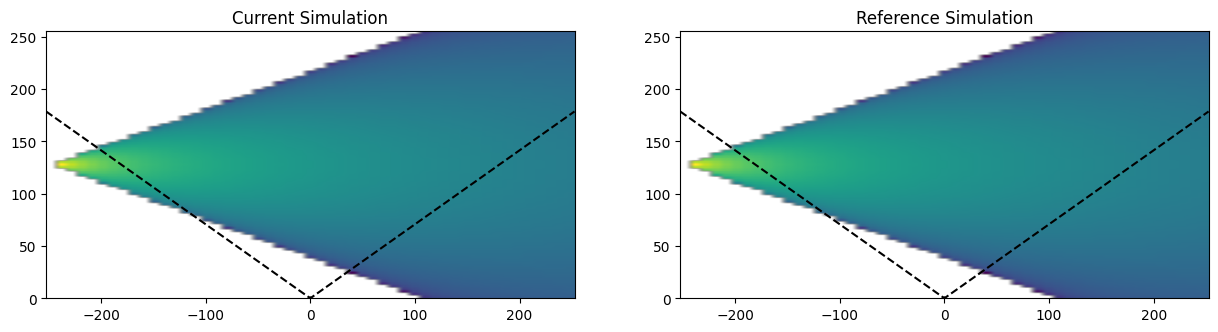

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

n, dx, grad = torch.load("data/grad.pt")
n = n.cpu().numpy()
dx = dx.cpu().numpy()
grad = torch.log(grad[:,:,0,0]).cpu().numpy()
ref_grad = torch.log(torch.load("ref/grad.pt")[:,:,0,0]).cpu().numpy()
x = np.linspace(-n[0]*dx[0]/2.*1e9, n[0]*dx[0]/2.*1e9, num = 200)

ax1.imshow(grad, origin = "lower", extent=(-n[0]*dx[0]/2.*1e9,n[0]*dx[0]/2.*1e9,0*1e9,n[1]*dx[1]*1e9))
ax1.plot(x, np.abs(x)/np.sqrt(2), "k--")
ax1.set_title("Current Simulation")

ax2.imshow(ref_grad, origin = "lower", extent=(-n[0]*dx[0]/2.*1e9,n[0]*dx[0]/2.*1e9,0*1e9,n[1]*dx[1]*1e9))
ax2.plot(x, np.abs(x)/np.sqrt(2), "k--")
ax2.set_title("Reference Simulation")

fig.savefig("data/results.png")